# Bayesian Methods for Multilevel Modeling of Neurons

Hierarchical or multilevel modeling is a generalization of regression modeling. *Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**. Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another. Some multilevel structures are not hierarchical -- e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters. We will motivate this topic using a neuroscience example.

Example: firing rate (modified Gelman and Hill 2006)

Firing rate is a measure of neuronal activity. It varies greatly from neuron to neuron.

The EPA did a study of radon levels in firing rate in 80,000 households (more on this study and modeling here https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/multilevel_modeling.html). We are going to call homes "neurons", counties "mice", and radon levels "firing rate." The firing rate is going to vary depending on "no_stim" (originally floor condition) or "stim" (originally basement condition) that in our case denote, say, optogenetic stimulation of prefrontal cortex. There are two important predictors:

* measurement in stim or first no_stim (firingrate higher in stims)
* mouse firing rate level (positive correlation with firingrate levels by mouse)

The hierarchy in this example is neurons within mouse. 

Following the authors, we are not considering the variability that comes from house identity, which would mean neuron identity in our neuroscience language.

## Data organization

First, we import the data from a local file, and extract data.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import warnings
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

In [3]:
az.style.use("arviz-darkgrid")
# Import firingrate data
srrs2 = pd.read_csv(pm.get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
# Select a subset of "mice" from Minnesota
srrs_mn = srrs2[srrs2.state=='MN'].copy()

Next, obtain the mouse-level predictor, firing rate, by combining two variables.

In [4]:
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [5]:
print(srrs_mn.columns,srrs_mn.shape)
print(cty_mn.columns,cty_mn.shape)

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips'],
      dtype='object') (919, 26)
Index(['stfips', 'ctfips', 'st', 'cty', 'lon', 'lat', 'Uppm', 'fips'], dtype='object') (89, 8)


Use the `merge` method to combine neuron- and mouse-level information in a single DataFrame.

In [6]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [7]:
srrs_mn['Uppm'].unique().shape,srrs_mn['activity'].unique().shape
#plt.scatter(srrs_mn['Uppm'],srrs_mn['activity'])

((85,), (156,))

In [8]:
# Rename environmental variables to represent 
# what we think of as a neuroscience example
srrs_mn.rename({'floor':'no_stim','basement':'stim','county':'mouse',
                'activity':'firingrate'},axis=1,inplace=True)

In [9]:
srrs_mn.head()

idnum state state2  stfips    zip  region  typebldg  no_stim  room stim  \
0   5081    MN     MN      27  55735       5         1        1     3    N   
1   5082    MN     MN      27  55748       5         1        0     4    Y   
2   5083    MN     MN      27  55748       5         1        0     4    Y   
3   5084    MN     MN      27  56469       5         1        0     4    Y   
4   5085    MN     MN      27  55011       3         1        0     4    Y   

   ...  stopdt firingrate  pcterr        adjwt  dupflag  zipflag  cntyfips  \
0  ...   12288        2.2     9.7  1146.499190        1        0         1   
1  ...   12088        2.2    14.5   471.366223        0        0         1   
2  ...   21188        2.9     9.6   433.316718        0        0         1   
3  ...  123187        1.0    24.3   461.623670        0        0         1   
4  ...   13088        3.1    13.8   433.316718        0        0         3   

                  mouse   fips      Uppm  
0  AITKIN                27001  0.502054  
1  AITKIN                27001  0.502054  
2  AITKIN                27001  0.502054  
3  AITKIN                27001  0.502054  
4  ANOKA                 27003  0.428565  

[5 rows x 27 columns]

We also need a lookup table (`dict`) for each unique mouse, for indexing.

In [10]:
srrs_mn.mouse = srrs_mn.mouse.map(str.strip)
mn_mice = srrs_mn.mouse.unique()
n_mice = len(mn_mice)
mouse_lookup = dict(zip(mn_mice, range(n_mice)))

Finally, create local copies of variables.

In [11]:
mouse = srrs_mn['mouse_code'] = srrs_mn.mouse.replace(mouse_lookup).values
firingrate = srrs_mn.firingrate
srrs_mn['log_firingrate'] = log_firingrate = np.log(firingrate + 0.1).values
no_stim = srrs_mn.no_stim.values

Distribution of firing rate levels (log scale):

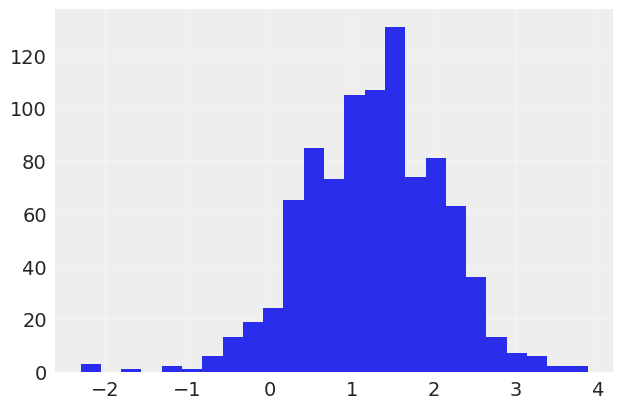

In [12]:
srrs_mn.log_firingrate.hist(bins=25);

## Conventional approaches

The two conventional alternatives to modeling firing rate exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all mice the same, and estimate a single firing rate level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model firing rate in each mouse independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-neuron variation, or variation among neurons.

We'll start by estimating the slope and intercept for the complete pooling model. You'll notice that we used an *index* variable instead of an *indicator* variable in the linear model below. There are two main reasons. One, this generalizes well to more-than-two-category cases. Two, this approach correctly considers that neither category has more prior uncertainty than the other. On the contrary, the indicator variable approach necessarily assumes that one of the categories has more uncertainty than the other: here, the cases when `no_stim=1` would take into account 2 priors ($\alpha + \beta$), whereas cases when `no_stim=0` would have only one prior ($\alpha$). But *a priori* we aren't more unsure about no_stim measurements than about stim measurements, so it makes sense to give them the same prior uncertainty.

Now for the model:

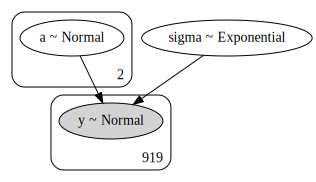

In [58]:
with pm.Model() as pooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=2)
    
    theta = a[no_stim]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    
pm.model_to_graphviz(pooled_model)

Before running the model let's do some prior predictive checks. Indeed, having sensible priors is not only a way to incorporate scientific knowledge into the model, it can also help and make the MCMC machinery faster -- here we are dealing with a simple linear regression, so no link function comes and distorts the outcome space; but one day this will happen to you and you'll need to think hard about your priors to help your MCMC sampler. So, better to train ourselves when it's quite easy than having to learn when it's very hard... There is a really neat function to do that in PyMC3:

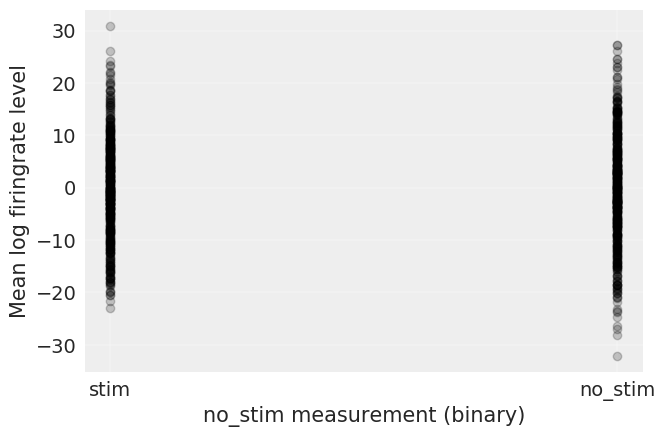

In [14]:
with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

plt.plot(
    [0, 1], 
    [prior_checks["a"][:, 0], prior_checks["a"][:, 1]],
    "ok",
    alpha=0.2)
plt.xlabel("no_stim measurement (binary)")
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log firingrate level");

I'm no expert in firingrate levels, but, before seing the data, these priors seem to allow for quite a wide range of the mean log firingrate level. But don't worry, we can always change these priors if sampling gives us hints that they might not be appropriate -- after all, priors are assumptions, not oaths; and as most assumptions, they can be tested.

However, we can already think of an improvement. Do you see it? Remember what we said at the beginning: firingrate levels tend to be higher in stims, so we could incorporate this prior scientific knowledge into our model by giving $a_{stim}$ a higher mean than $a_{no_stim}$. Here, there are so much data that the prior should be washed out anyway, but we should keep this fact in mind -- for future cases or if sampling proves more difficult than expected...

Speaking of sampling, let's fire up the Bayesian machinery!

In [15]:
with pooled_model:
    pooled_trace = pm.fit()

Average Loss = 1,154.2: 100%|██████████| 10000/10000 [00:02<00:00, 4848.69it/s]
Finished [100%]: Average Loss = 1,154


In [16]:
dir(pooled_trace)

['_Group__name_registry',
 '_Group__param_registry',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_group__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__param_spec__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batched',
 '_cache',
 '_check_user_params',
 '_finalize_init',
 '_group_class',
 '_initial_type',
 '_input_type',
 '_local',
 '_new_initial',
 '_new_initial_shape',
 '_rng',
 '_scale_cost_to_minibatch',
 '_single_symbolic_varlogp_and_datalogp',
 '_sized_symbolic_varlogp_and_datalogp',
 '_user_params',
 '_vfam',
 'alias_names',
 'all_histograms',
 'any_histograms',
 'batched',
 'bdim',
 'bij',
 'collect',
 'cov',
 'create_shared_params',
 'datalogp',
 'datalogp_norm',
 'ddim',
 'get

In [17]:
with pooled_model:
    start = pm.find_MAP()
    pooled_trace = pm.sample(1000, pm.NUTS(scaling=start), start=start, random_seed=RANDOM_SEED)
az.summary(pooled_trace, round_to=2)

logp = -1,093.8, ||grad|| = 8.8772: 100%|██████████| 15/15 [00:00<00:00, 1956.72it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:01<00:00, 4652.58draws/s]


mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0]   1.36  0.03    1.31     1.42        0.0      0.0   5380.52  5376.74   
a[1]   0.78  0.06    0.66     0.90        0.0      0.0   5739.46  5638.92   
sigma  0.79  0.02    0.76     0.83        0.0      0.0   5958.97  5910.27   

       ess_bulk  ess_tail  r_hat  
a[0]    5383.84   2931.47    1.0  
a[1]    5757.81   2581.28    1.0  
sigma   6024.21   3137.22    1.0

In [18]:
with pooled_model:
    pooled_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
az.summary(pooled_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:02<00:00, 4433.49draws/s]


mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a[0]   1.36  0.03    1.31     1.42        0.0      0.0   5337.39  5318.27   
a[1]   0.77  0.06    0.66     0.89        0.0      0.0   5036.60  5036.60   
sigma  0.79  0.02    0.75     0.82        0.0      0.0   4937.42  4935.28   

       ess_bulk  ess_tail  r_hat  
a[0]    5344.21   2976.04    1.0  
a[1]    5050.29   2491.71    1.0  
sigma   4922.16   3068.15    1.0

No divergences and a sampling that only took seconds -- this is the Flash of samplers! Here the chains look very good (good R hat, good effective sample size, small sd), but remember to check your chains after sampling -- `az.traceplot` is usually a good start.

Let's see what it means on the outcome space: did the model pick-up the negative relationship between no_stim measurements and log firingrate levels? What's the uncertainty around its estimates? To estimate the uncertainty around the neuron firingrate levels (not the average level, but measurements that would be likely in neurons), we need to sample the likelihood `y` from the model. In another words, we need to do posterior predictive checks:

In [19]:
with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)["y"]

a_stim, a_no_stim = pooled_trace["a"].mean(axis=0)
firingrate_stim, firingrate_no_stim = ppc[:, 1], ppc[:, 0] # we know that no_stim=0/1 at these columns

100%|██████████| 4000/4000 [00:03<00:00, 1231.07it/s]


We can then use these samples in our plot:

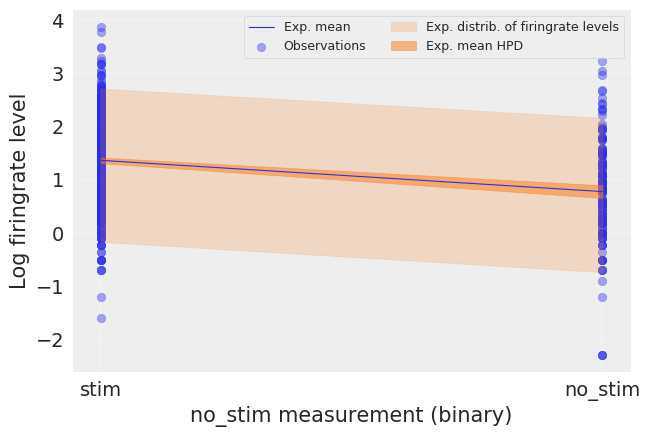

In [20]:
plt.scatter(no_stim, log_firingrate, label="Observations", alpha=0.4)

az.plot_hpd(
    [0, 1], 
    np.asarray([firingrate_stim, firingrate_no_stim]).T, 
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of firingrate levels"}
)
az.plot_hpd(
    [0, 1], 
    pooled_trace["a"], 
    fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}
)
plt.plot([0, 1], [a_stim, a_no_stim], label="Exp. mean")

plt.xticks([0,1], ["stim", "no_stim"])
plt.xlabel("no_stim measurement (binary)")
plt.ylabel("Log firingrate level")
plt.legend(ncol=2, fontsize=9, frameon=True);

The 94% interval of the expected value is very narrow, and even narrower for stim measurements, meaning that the model is slightly more confident about these observations. The sampling distribution of individual firingrate levels is much wider. We can infer that no_stim level does account for some of the variation in firingrate levels. We can see however that the model underestimates the dispersion in firingrate levels across neurons -- lots of them lie outside the light orange prediction envelope. So this model is a good start but we can't stop there.

Let's compare it to the unpooled model, where we estimate the firingrate level for each mouse:

In [21]:
n_mice,no_stim.shape,log_firingrate.shape

(85, (919,), (919,))

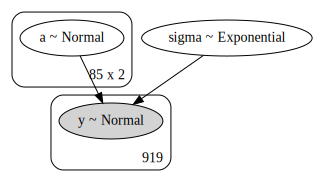

In [57]:
# updated version:
with pm.Model() as unpooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=(n_mice, 2))
    
    theta = a[mouse, no_stim]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)

pm.model_to_graphviz(unpooled_model)

In [23]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:09<00:00, 1325.67draws/s]


Sampling went fine again. Let's look at the expected values for both stim (dimension 0) and no_stim (dimension 1) in each mouse:

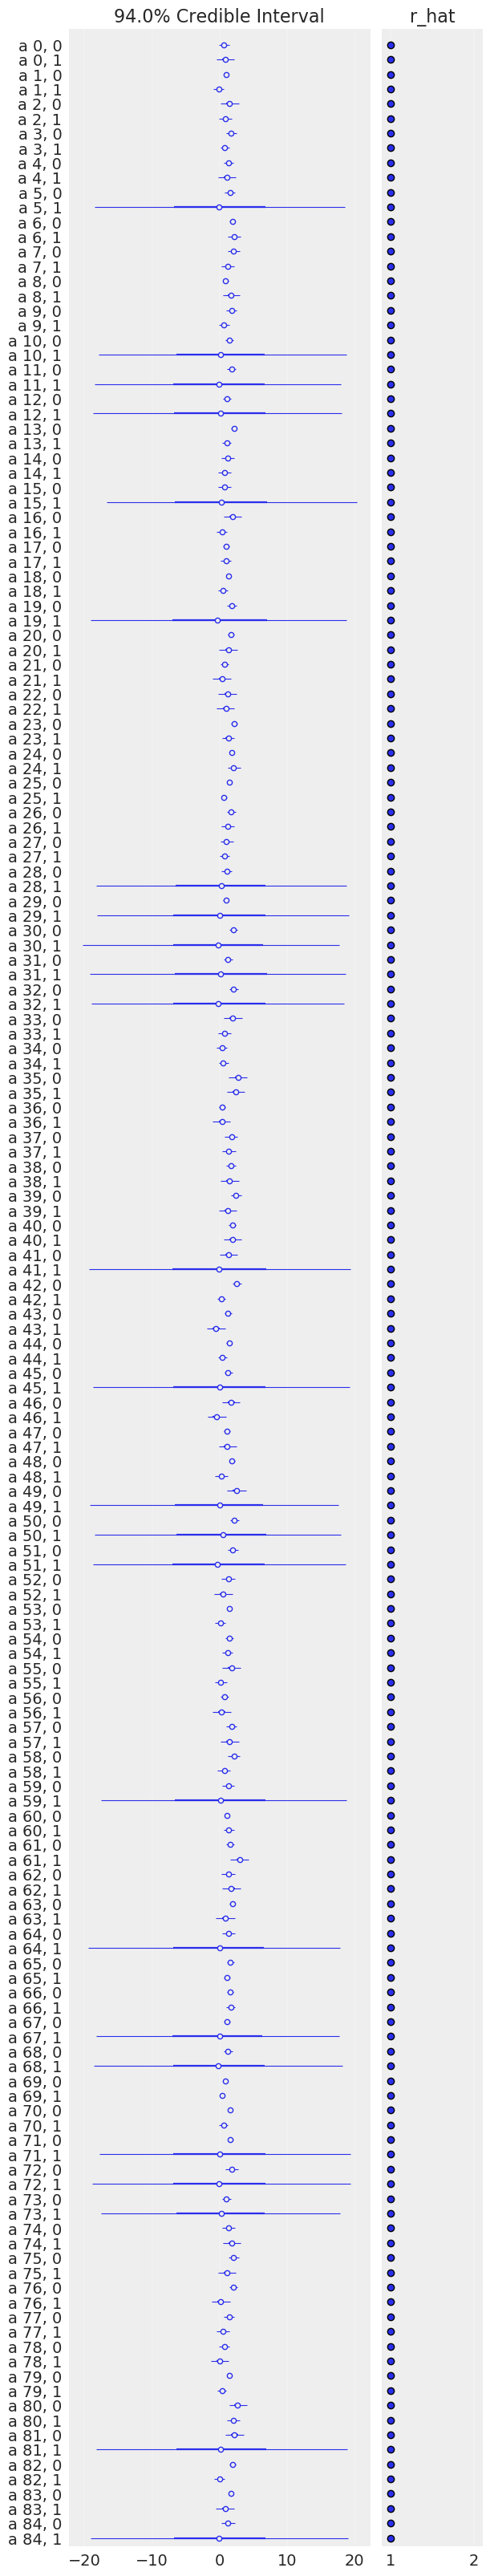

In [24]:
az.plot_forest(unpooled_trace, var_names=['a'], figsize=(6, 32), r_hat=True, combined=True);

Sampling was good for all mice, but you can see that some are more uncertain than others, and all of these uncertain estimates are for no_stim measurements. This probably comes from the fact that some mice just have a handful of no_stim measurements, so the model is pretty uncertain about them.

To identify mice with high firing rate levels, we can plot the ordered mean estimates, as well as their 94% HPD:

In [25]:
a_stim_unpooled, a_no_stim_unpooled = unpooled_trace["a"][:, :, 0], unpooled_trace["a"][:, :, 1]
unpooled_stim = pd.DataFrame.from_dict(
                        {
                            "stim": a_stim_unpooled.mean(0), 
                            "low": az.hpd(a_stim_unpooled)[:, 0], 
                            "high": az.hpd(a_stim_unpooled)[:, 1]
                        }, 
                        orient="index", 
                        columns=mn_mice
                    ).T.sort_values(by="stim")
unpooled_no_stim = pd.DataFrame.from_dict(
                    {
                        "no_stim": a_no_stim_unpooled.mean(0),
                        "low": az.hpd(a_no_stim_unpooled)[:, 0], 
                        "high": az.hpd(a_no_stim_unpooled)[:, 1]
                    }, 
                    orient="index", 
                    columns=mn_mice
                ).T.sort_values(by="no_stim")

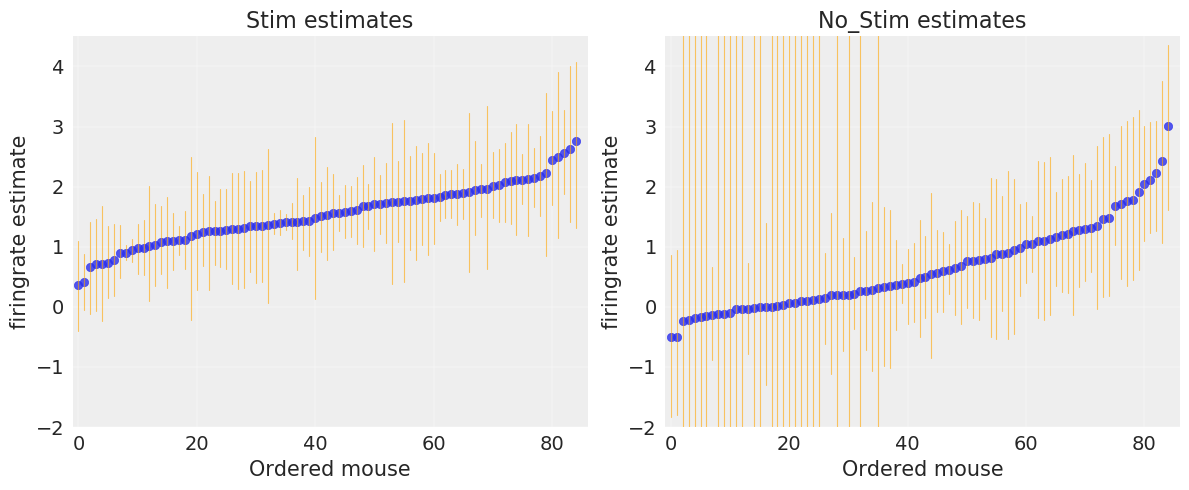

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, estimates, level in zip(axes, [unpooled_stim, unpooled_no_stim], ["stim", "no_stim"]):    
    for i, l, h in zip(range(n_mice), estimates.low.values, estimates.high.values):
        ax.plot([i, i], [l, h], alpha=0.6, c='orange')
    ax.scatter(range(n_mice), estimates[level], alpha=0.8)
    ax.set(title=f"{level.title()} estimates", xlabel="Ordered mouse", xlim=(-1, 86), ylabel="firingrate estimate", ylim=(-2, 4.5))
plt.tight_layout();

There seems to be more dispersion in firingrate levels for no_stim measurements than for stim ones. Moreover, as we saw in the forest plot, no_stim estimates are globally more uncertain, especially in some mice. We speculated that this is due to smaller sample sizes in the data, but let's verify it!

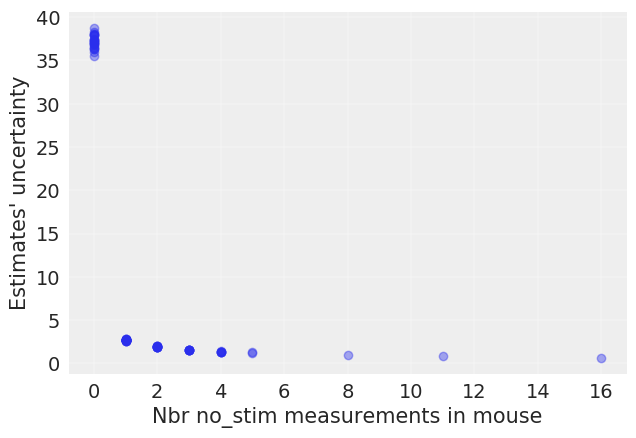

In [27]:
n_no_stim_meas = srrs_mn.groupby("mouse").sum().no_stim
uncertainty = (unpooled_no_stim.high - unpooled_no_stim.low).sort_index() # sort index to match counties alphabetically

plt.plot(n_no_stim_meas, uncertainty, 'o', alpha=.4)
plt.xlabel("Nbr no_stim measurements in mouse")
plt.ylabel("Estimates' uncertainty");

Bingo! This makes sense: it's very hard to estimate no_stim firingrate levels in mice where there are no no_stim measurements, and the model is telling us that by being very uncertain in its estimates for those mice. This is a classic issue with no-pooling models: when you estimate clusters independently from each other, what do you with small-sample-size mice?

Another way to see this phenomenon is to visually compare the pooled and unpooled estimates for a subset of mice representing a range of sample sizes:

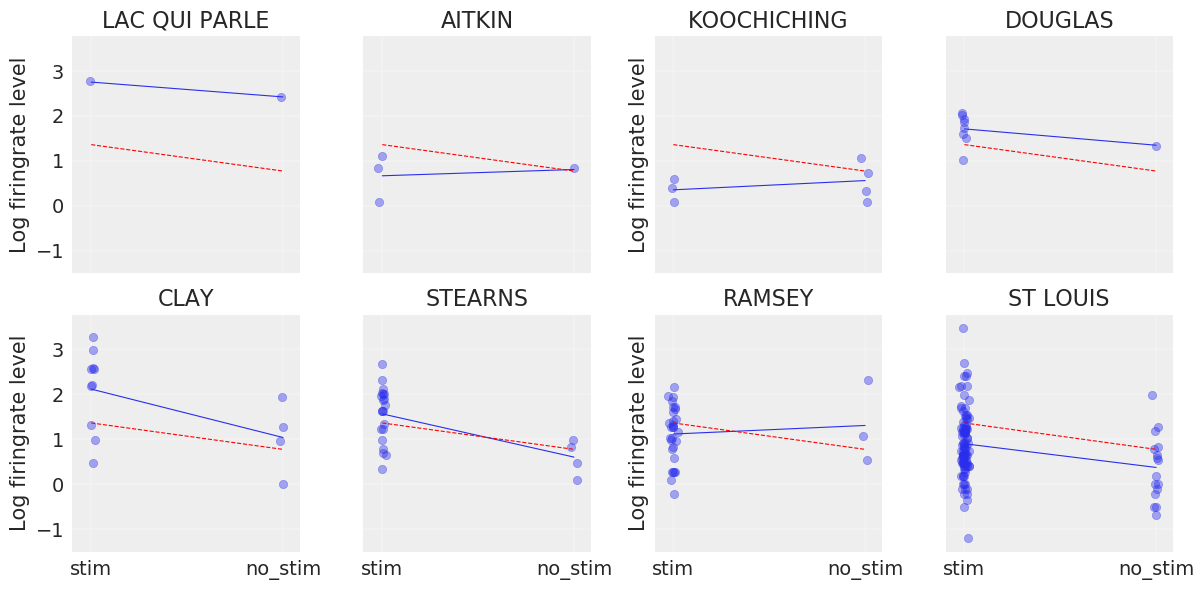

In [28]:
# These mice were named as counties in Minnesota, how curious
SAMPLE_mice = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel() 
for i, c in enumerate(SAMPLE_mice):
    x = srrs_mn.no_stim[srrs_mn.mouse==c]
    y = srrs_mn.log_firingrate[srrs_mn.mouse==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # plot both models:
    axes[i].plot([0, 1], [unpooled_stim.loc[c, "stim"] , unpooled_no_stim.loc[c, "no_stim"]])
    axes[i].plot([0, 1], [a_stim, a_no_stim], "r--")
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["stim", "no_stim"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log firingrate level")
plt.tight_layout();

Neither of these models are satisfactory:

* If we are trying to identify high-firingrate mice, pooling is useless -- because, by definition, the pooled model estimates firingrate at the state-level. In other words, pooling leads to maximal *underfitting*: the variation across mice is not taken into account and only the overall population is estimated.
* We do not trust extreme unpooled estimates produced by models using few observations. This leads to maximal *overfitting*: only the within-mouse variations are taken into account and the overall population (i.e the state-level, which tells us about similarites across mice) is not estimated. 

This issue is acute for small sample sizes, as seen above: in mice where we have few no_stim measurements, if firingrate levels are higher for those data points than for stim ones (Aitkin, Koochiching, Ramsey), the model will estimate that firingrate levels are higher in no_stims than stims for these mice. But we shouldn't trust this conclusion, because both scientific knowledge and the situation in other mice tell us that it is usually the reverse (stim firingrate > no_stim firingrate). So unless we have a lot of observations telling us otherwise for a given mouse, we should be skeptical and shrink our mouse-estimates to the state-estimates -- in other words, we should balance between cluster-level and population-level information, and the amount of shrinkage will depend on how extreme and how numerous the data in each cluster are. 

But how do we do that? Well, ladies and gentlemen, let me introduce you to... hierarchical models!

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance) -- we assume that mice are all the same:

![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them -- we assume that mice have no similarity whatsoever:

![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the neuron firingrate dataset is one which simply estimates firingrate levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled mouse estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for mice with smaller sample sizes will shrink towards the state-wide average.

Estimates for mice with larger sample sizes will be closer to the unpooled mouse estimates and will influence the the state-wide average.

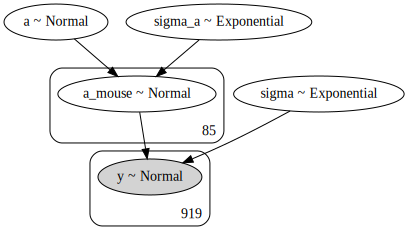

In [56]:
with pm.Model() as partial_pooling:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    
    # Expected value per mouse:
    theta = a_mouse[mouse]
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(partial_pooling)

In [30]:
with partial_pooling:
    partial_pooling_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_mouse, sigma_a, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2106.30draws/s]
The number of effective samples is smaller than 25% for some parameters.


To compare partial-pooling and no-pooling estimates, let's run the unpooled model without the `no_stim` predictor:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_mouse]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:04<00:00, 2745.42draws/s]


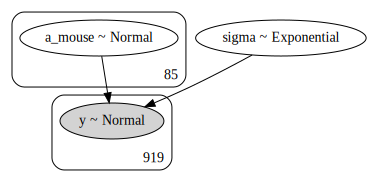

In [53]:
with pm.Model() as unpooled_bis:
    a_mouse = pm.Normal('a_mouse', 0., sigma=10., shape=n_mice)
    
    theta = a_mouse[mouse]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    
    unpooled_trace_bis = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
pm.model_to_graphviz(unpooled_bis)

Now let's compare both models' estimates for all 85 mice. We'll plot the estimates against each mouse's sample size, to let you see more clearly what hierarchical models bring to the table:

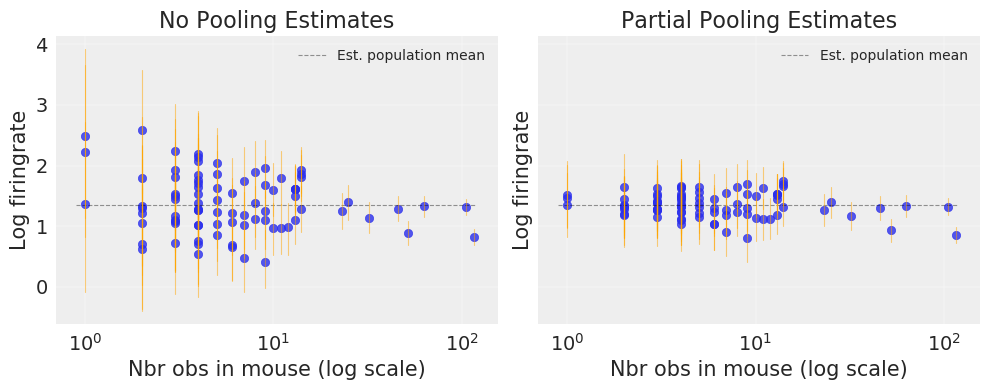

In [32]:
N_mouse = srrs_mn.groupby("mouse")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes, 
    [unpooled_trace_bis["a_mouse"], partial_pooling_trace["a_mouse"]], 
    ["no pooling", "partial pooling"]
):
    ax.hlines(
        partial_pooling_trace["a"].mean(), 
        0.9, 
        max(N_mouse) + 1, 
        alpha=0.4, 
        ls="--", 
        label="Est. population mean"
    )
    for n, l, h in zip(
        N_mouse, 
        az.hpd(trace)[:, 0], 
        az.hpd(trace)[:, 1]
    ):
        ax.plot([n, n], [l, h], alpha=0.5, c="orange")
    ax.scatter(N_mouse, trace.mean(0), alpha=0.8)
    ax.set(
        title=f"{level.title()} Estimates", 
        xlabel="Nbr obs in mouse (log scale)", 
        xscale="log", 
        ylabel="Log firingrate"
    )
    ax.legend(fontsize=10)
plt.tight_layout();

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former are both more extreme and more imprecise. Indeed, in the partially-pooled model, estimates in small-sample-size mice are informed by the population parameters -- hence more precise estimates. Moreover, the smaller the sample size, the more regression towards the overall mean (the dashed gray line) -- hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in mice where data is sparse. 

Now let's try to integrate the `no_stim` predictor! To show you an example with a slope we're gonna take the indicator variable road, but we could stay with the index variable approach that we used for the no-pooling model. Then we would have one intercept for each category -- stim and no_stim.

## Varying intercept model

As above, this model allows intercepts to vary across mouse, according to a random effect. We just add a fixed slope for the predictor (i.e all mice will have the same slope):

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the no-pooling model, we set a separate intercept for each mouse, but rather than fitting separate regression models for each mouse, multilevel modeling **shares strength** among mice, allowing for more reasonable inference in mice with little data. Here is what that looks in code:

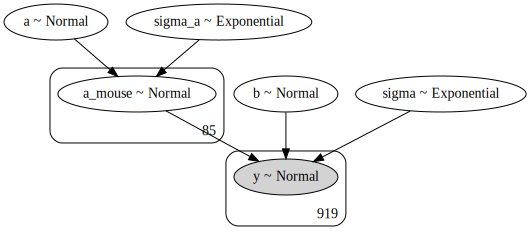

In [55]:
with pm.Model() as varying_intercept:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=10.)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept)

Let's fit this bad boy with MCMC:

In [34]:
with varying_intercept:
    varying_intercept_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a_mouse, sigma_a, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2145.26draws/s]


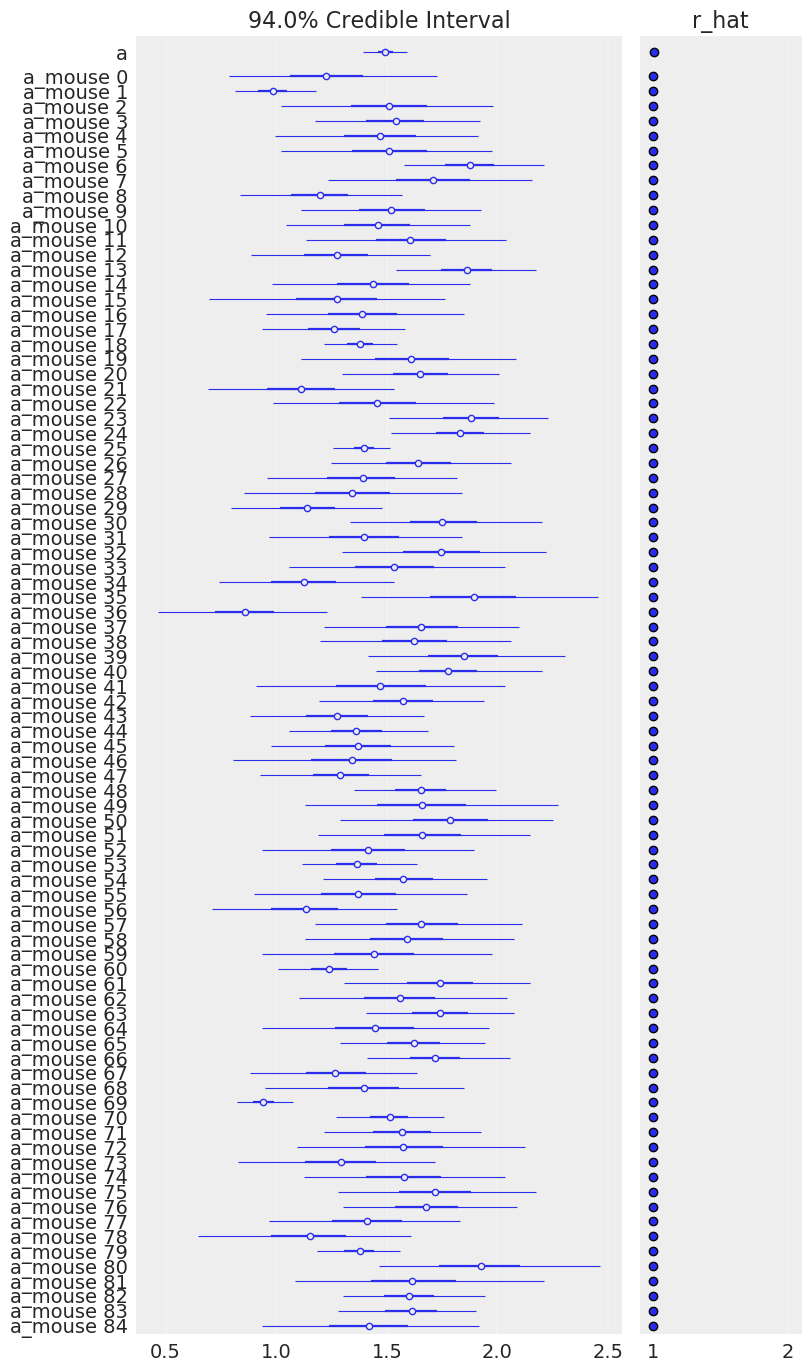

In [35]:
az.plot_forest(varying_intercept_trace, var_names=["a", "a_mouse"], r_hat=True, combined=True);

/home/m/anaconda3/envs/simple/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/m/anaconda3/envs/simple/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


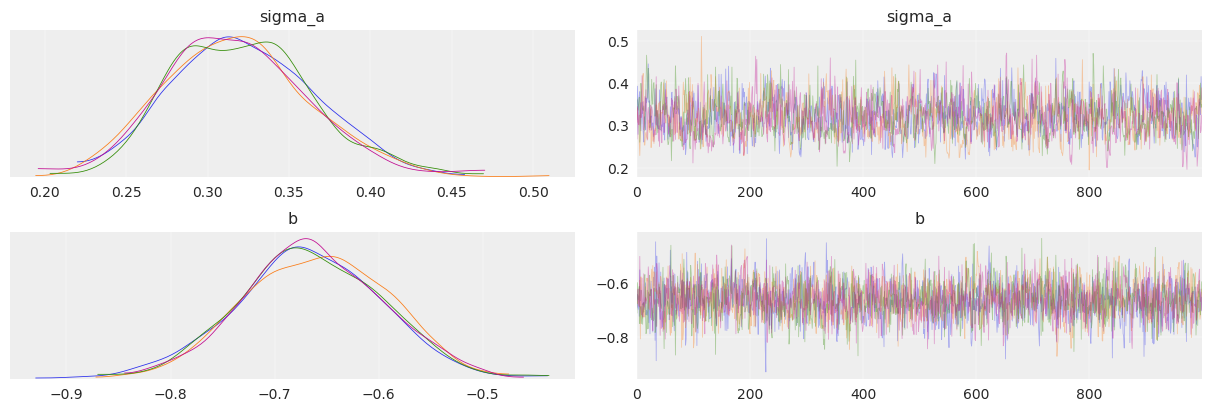

In [36]:
az.plot_trace(varying_intercept_trace, var_names=["sigma_a", "b"]);

In [37]:
az.summary(varying_intercept_trace, var_names=["a", "sigma_a", "b", "sigma"], round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
a        1.49  0.05    1.39     1.59        0.0      0.0   1768.72  1768.72   
sigma_a  0.32  0.04    0.24     0.40        0.0      0.0   1121.26  1121.26   
b       -0.66  0.07   -0.79    -0.54        0.0      0.0   2553.22  2543.76   
sigma    0.73  0.02    0.69     0.76        0.0      0.0   5094.12  5094.12   

         ess_bulk  ess_tail  r_hat  
a         1766.97   2555.46   1.01  
sigma_a   1099.47   1636.59   1.00  
b         2554.17   2760.70   1.00  
sigma     5045.91   2638.72   1.00

As we suspected, the estimate for the `no_stim` coefficient is reliably negative and centered around -0.66. This can be interpreted as neurons without stims having about half ($\exp(-0.66) = 0.52$) the firingrate levels of those with stims, after accounting for mouse. Note that this is only the *relative* effect of no_stim on firingrate levels: conditional on being in a given mouse, firingrate is expected to be half lower in neurons without stims than in neurons with. To see how much difference a stim makes on the *absolute* level of firingrate, we'd have to push the parameters through the model, as we do with posterior predictive checks and as we'll do just now.

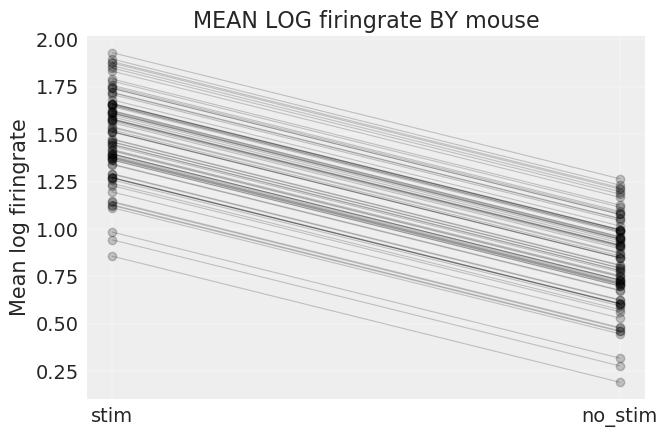

In [38]:
xvals = np.arange(2)
avg_a_mouse = varying_intercept_trace["a_mouse"].mean(0)
avg_b = varying_intercept_trace["b"].mean()

for a_c in avg_a_mouse:
    plt.plot(xvals, a_c + avg_b * xvals, 'ko-', alpha=0.2)
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log firingrate")
plt.title("MEAN LOG firingrate BY mouse");

The graph above shows, for each mouse, the expected log firingrate level and the average effect of having no stim -- these are the absolute effects we were talking about. Two caveats though:
1. This graph doesn't show the uncertainty for each mouse -- how confident are we that the average estimates are where the graph shows? For that we'd need to combine the uncertainty in `a_mouse` and `b`, and this would of course vary by mouse. I didn't show it here because the graph would get cluttered, but go ahead and do it for a subset of mice.
2. These are only *average* estimates at the *mouse-level* (`theta` in the model): they don't take into account the variation by neuron. To add this other layer of uncertainty we'd need to take stock of the effect of `sigma` and generate samples from the `y` variable to see the effect on given neurons (that's exactly the role of posterior predictive checks).

That being said, it is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for mice with small sample sizes:

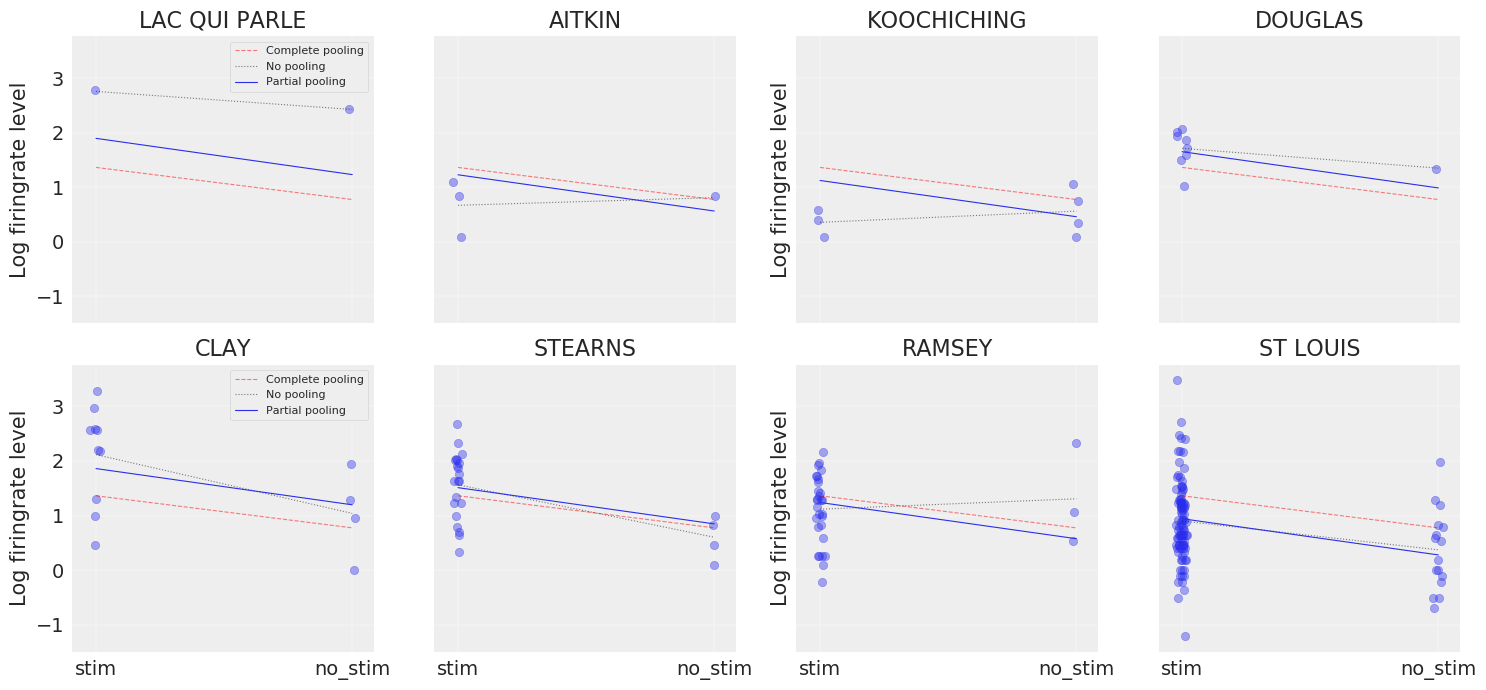

In [39]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.ravel()
for i, c in enumerate(SAMPLE_mice):
    x = srrs_mn.no_stim[srrs_mn.mouse==c]
    y = srrs_mn.log_firingrate[srrs_mn.mouse==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    # complete-pooling model:
    axes[i].plot([0, 1], [a_stim, a_no_stim], "r--", alpha=0.5, label="Complete pooling")
    # no-pooling model:
    axes[i].plot(
        [0, 1], 
        [unpooled_stim.loc[c, "stim"] , unpooled_no_stim.loc[c, "no_stim"]],
        "k:",
        alpha=0.5,
        label="No pooling"
    )
    # partial-pooling model:
    axes[i].plot(
        [0, 1], 
        [avg_a_mouse[mouse_lookup[c]], avg_a_mouse[mouse_lookup[c]] + avg_b],
        label="Partial pooling"
    )
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["stim", "no_stim"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log firingrate level")
    if not i%4:
        axes[i].legend(fontsize=8, frameon=True)
plt.tight_layout();

Here we clearly see the notion that partial-pooling is a compromise between no pooling and complete pooling, as its mean estimates are usually between the other models' estimates. And interestingly, the bigger (smaller) the sample size in a given mouse, the closer the partial-pooling estimates are to the no-pooling (complete-pooling) estimates.

We see however that mice vary by more than just their baseline rates: the effect of no_stim seems to be different from one mouse to another. It would be great if our model could take that into account, wouldn't it? Well to do that, we need to allow the slope to vary by mouse -- not only the intercept -- and here is how you can do it with PyMC3.

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by mouse:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

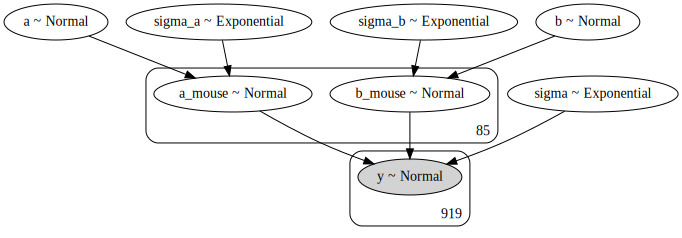

In [49]:
with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Varying slopes:
    b_mouse = pm.Normal('b_mouse', mu=b, sigma=sigma_b, shape=n_mice)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b_mouse[mouse] * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

## Reparametrization

Now, if you run this model, you'll get divergences (some or a lot, depending on your random seed). We don't want that -- divergences are your Voldemort to your models. In these situations it's usually wise to reparametrize your model using the "non-centered parametrization" (I know, it's really not a great term, but please indulge me). We're not gonna explain it here, but there are [great resources out there](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/). In a nutshell, it's an algebraic trick that helps computation but leaves the model unchanged -- the model is statistically equivalent to the "centered" version. In that case, here is what it would look like:

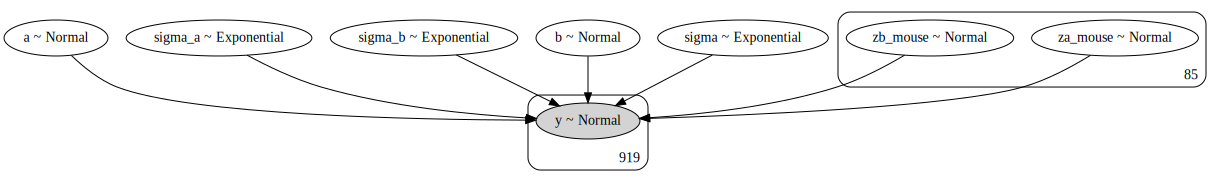

In [43]:
with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    # Varying slopes:
    zb_mouse = pm.Normal('zb_mouse', mu=0., sigma=1., shape=n_mice)
    
    # Expected value per mouse:
    theta = (a + za_mouse[mouse] * sigma_a) + (b + zb_mouse[mouse] * sigma_b) * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

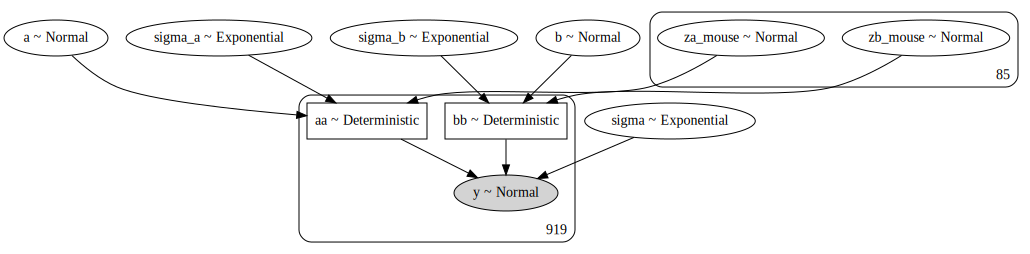

In [48]:
with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    # Varying slopes:
    zb_mouse = pm.Normal('zb_mouse', mu=0., sigma=1., shape=n_mice)
    
    # Expected value per mouse:
    aa=pm.Deterministic('aa', a + za_mouse[mouse] * sigma_a)
    bb = pm.Deterministic('bb', b + zb_mouse[mouse] * sigma_b)
    theta = aa + bb * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

In [56]:
with varying_intercept_slope:    
    varying_intercept_slope_trace = pm.sample(1000, tune=6000, target_accept=0.99, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, zb_mouse, za_mouse, sigma_b, b, sigma_a, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [01:23<00:00, 335.48draws/s]
The number of effective samples is smaller than 25% for some parameters.


True, the code is uglier (for you, not for the computer), but:
1. The interpretation stays pretty much the same: `a` and `b` are still the mean state-wide intercept and slope. `sigma_a` and `sigma_b` still estimate the dispersion across mice of the intercepts and slopes (the more alike the mice, the smaller the corresponding sigma). The big change is that now the mice estimates (`za_mouse` and `zb_mouse`) are z-scores. But the strategy to see what this means for mean firingrate levels per mouse is the same: push all these parameters through the model to get samples from `theta`.
2. We don't have any divergence: the model sampled more efficiently and converged more quickly than in the centered form.

Notice however that we had to increase the number of tuning steps. Looking at the trace helps us understand why:

/home/myroshnychenkm2/anaconda3/envs/simple/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/myroshnychenkm2/anaconda3/envs/simple/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/myroshnychenkm2/anaconda3/envs/simple/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/myroshnychenkm2/anaconda3/envs/simple/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

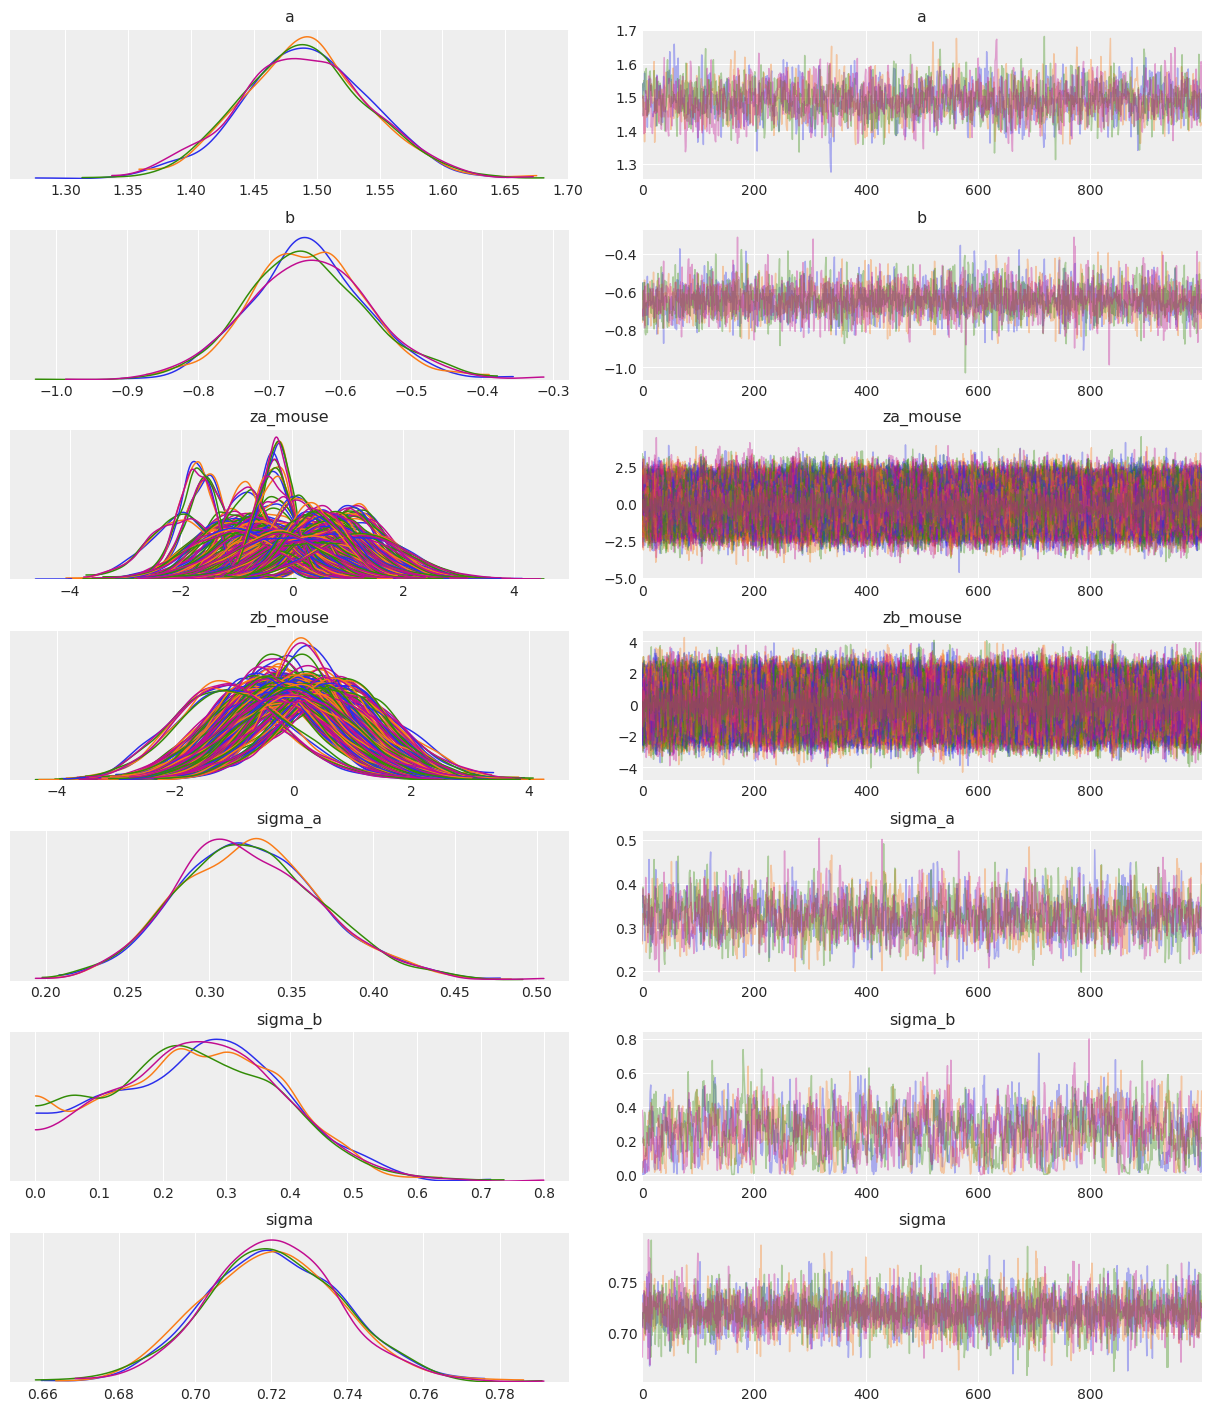

In [99]:
az.plot_trace(varying_intercept_slope_trace, compact=True);

All chains look good and we get a negative `b` coefficient, illustrating the mean downward effect of no-stim on firingrate levels at the state level. But notice that `sigma_b` often gets very near zero -- which would indicate that mice don't vary that much in their answer to the `no_stim` "treatment". That's probably what bugged MCMC when using the centered parametrization: these situations usually yield a weird geometry for the sampler, causing the divergences. In other words, the non-centered form often perfoms better when one of the sigmas gets close to zero. But here, even with the non-centered model the sampler is not that comfortable with `sigma_b`: in fact if you look at the estimates with `az.summary` you'll probably see that the number of effective samples is quite low for `sigma_b`.

Also note that `sigma_a` is not that big either -- i.e mice do differ in their baseline firingrate levels, but not by a lot. However we don't that much of a problem to sample from this distribution because it's much narrower than `sigma_b` and doesn't get dangerously close to 0.

To wrap up this model, let's plot the relationship between firingrate and no_stim for each mouse:

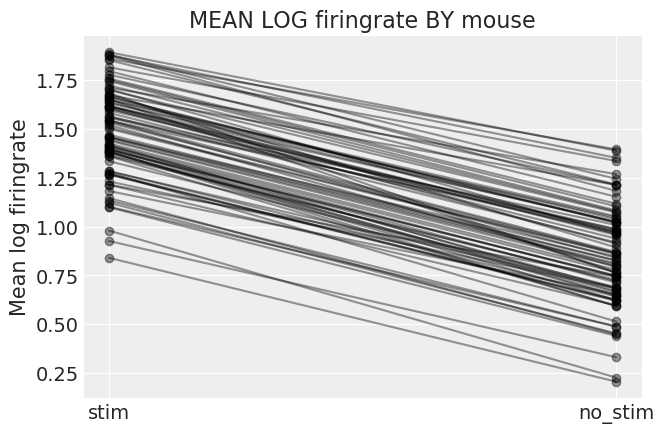

In [100]:
xvals = np.arange(2)
avg_a_mouse = (
    varying_intercept_slope_trace["a"].mean() 
    + varying_intercept_slope_trace["za_mouse"].mean(0) 
    * varying_intercept_slope_trace["sigma_a"].mean()
)
avg_b_mouse = (
    varying_intercept_slope_trace["b"].mean() 
    + varying_intercept_slope_trace["zb_mouse"].mean(0) 
    * varying_intercept_slope_trace["sigma_b"].mean()
)

for a_c, b_c in zip(avg_a_mouse, avg_b_mouse):
    plt.plot(xvals, a_c + b_c * xvals, 'ko-', alpha=0.4)
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log firingrate")
plt.title("MEAN LOG firingrate BY mouse");

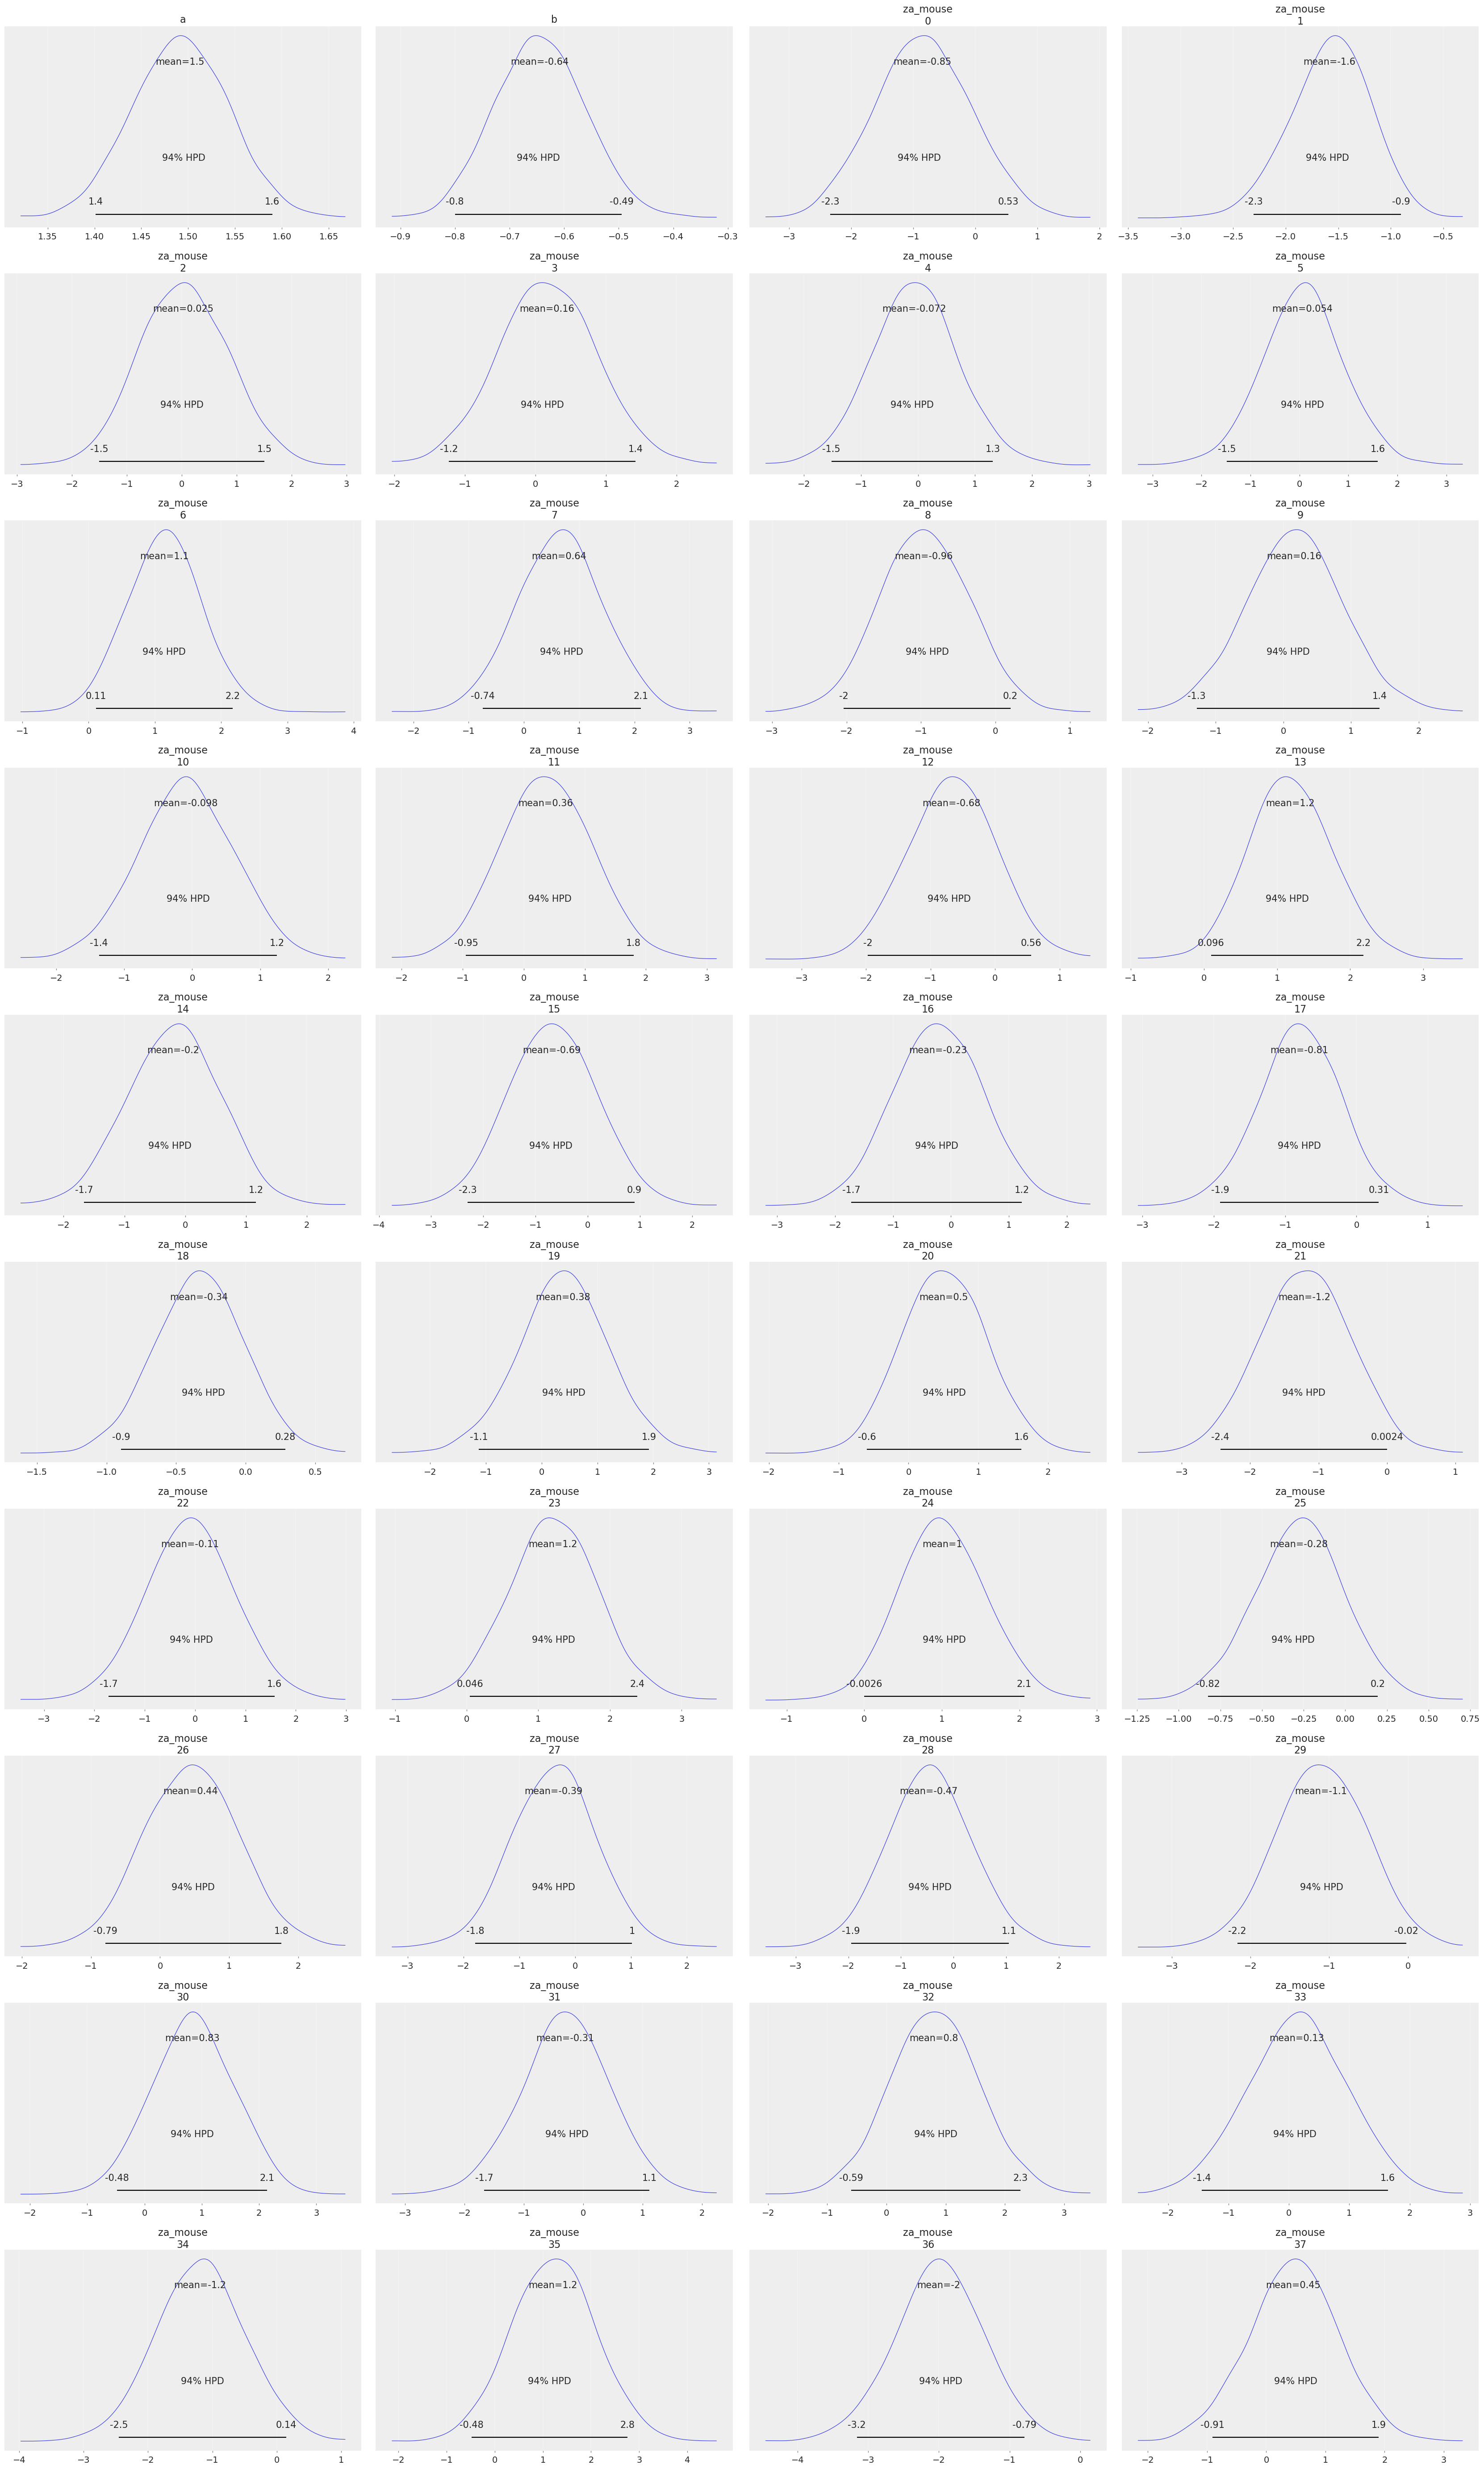

In [61]:
_=az.plot_posterior(varying_intercept_slope_trace)

With the same caveats as earlier, we can see that now *both* the intercept and the slope vary by mouse -- and isn't that a marvel of statistics? But wait, there is more! 

We can (and maybe should) take into account the covariation between intercepts and slopes: when baseline firingrate is low in a given mouse, maybe that means the difference between no_stim and stim measurements will decrease -- because there isn't that much firingrate anyway. That would translate into a positive correlation between `a_mouse` and `b_mouse`, and adding that into our model would make even more efficient use the available data. 

Or maybe the correlation is negative? In any case, we can't know that unless we model it. To do that, we'll use a multivariate Normal distribution instead of two different Normals for `a_mouse` and `b_mouse`. This simply means that each mouse's parameters come from a common distribution with mean `a` for intercepts and `b` for slopes, and slopes and intercepts co-vary according to the covariance matrix `S`. In mathematical form:

$$y \sim Normal(\firingrate, \sigma)$$

$$\firingrate = \alpha_{mouse} + \beta_{mouse} \times no_stim$$

$$\begin{bmatrix} \alpha_{mouse} \\ \beta_{mouse} \end{bmatrix} \sim MvNormal(\begin{bmatrix} \alpha \\ \beta \end{bmatrix}, \Sigma)$$

$$\Sigma = \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}
     P
     \begin{pmatrix} \sigma_{\alpha} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix}$$
     
where $\alpha$ and $\beta$ are the mean intercept and slope respectively, $\sigma_{\alpha}$ and $\sigma_{\beta}$ represent the variation in intercepts and slopes respectively, and $P$ is the correlation matrix of intercepts and slopes. In this case, as their is only one slope, $P$ contains only one relevant figure: the correlation between $\alpha$ and $\beta$.

This translates quite easily in PyMC3:

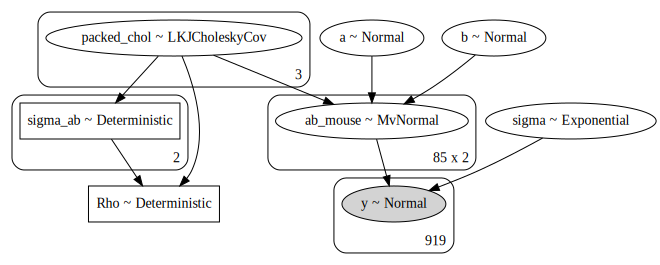

In [47]:
with pm.Model() as covariation_intercept_slope:
    # prior stddev in intercepts & slopes (variation across mice):
    sd_dist = pm.Exponential.dist(0.5)
    packed_chol = pm.LKJCholeskyCov('packed_chol', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    
    # extract standard deviations and rho:
    cov = pm.math.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # prior for average intercept:
    a = pm.Normal('a', mu=0., sigma=5.)
    # prior for average slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    # population of varying effects:
    ab_mouse = pm.MvNormal('ab_mouse', mu=tt.stack([a, b]), chol=chol, shape=(n_mice, 2))
    
    # Expected value per mouse:
    theta = ab_mouse[mouse, 0] + ab_mouse[mouse, 1] * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(covariation_intercept_slope)

This is by far the most complex model we've done so far, so it's normal if you're confused. Just take some time to let it sink in. The centered version mirrors the mathematical notions very closely, so you should be able to get the gist of it. Of course, you guessed it, we're gonna need the non-centered version. There is actually just one change:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, z, b, a, packed_chol]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [06:31<00:00, 71.50draws/s] 
The acceptance probability does not match the target. It is 0.7658394689226767, but should be close to 0.99. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9281687360940045, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/myroshnychenkm2/anaconda3/envs/simple/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has n

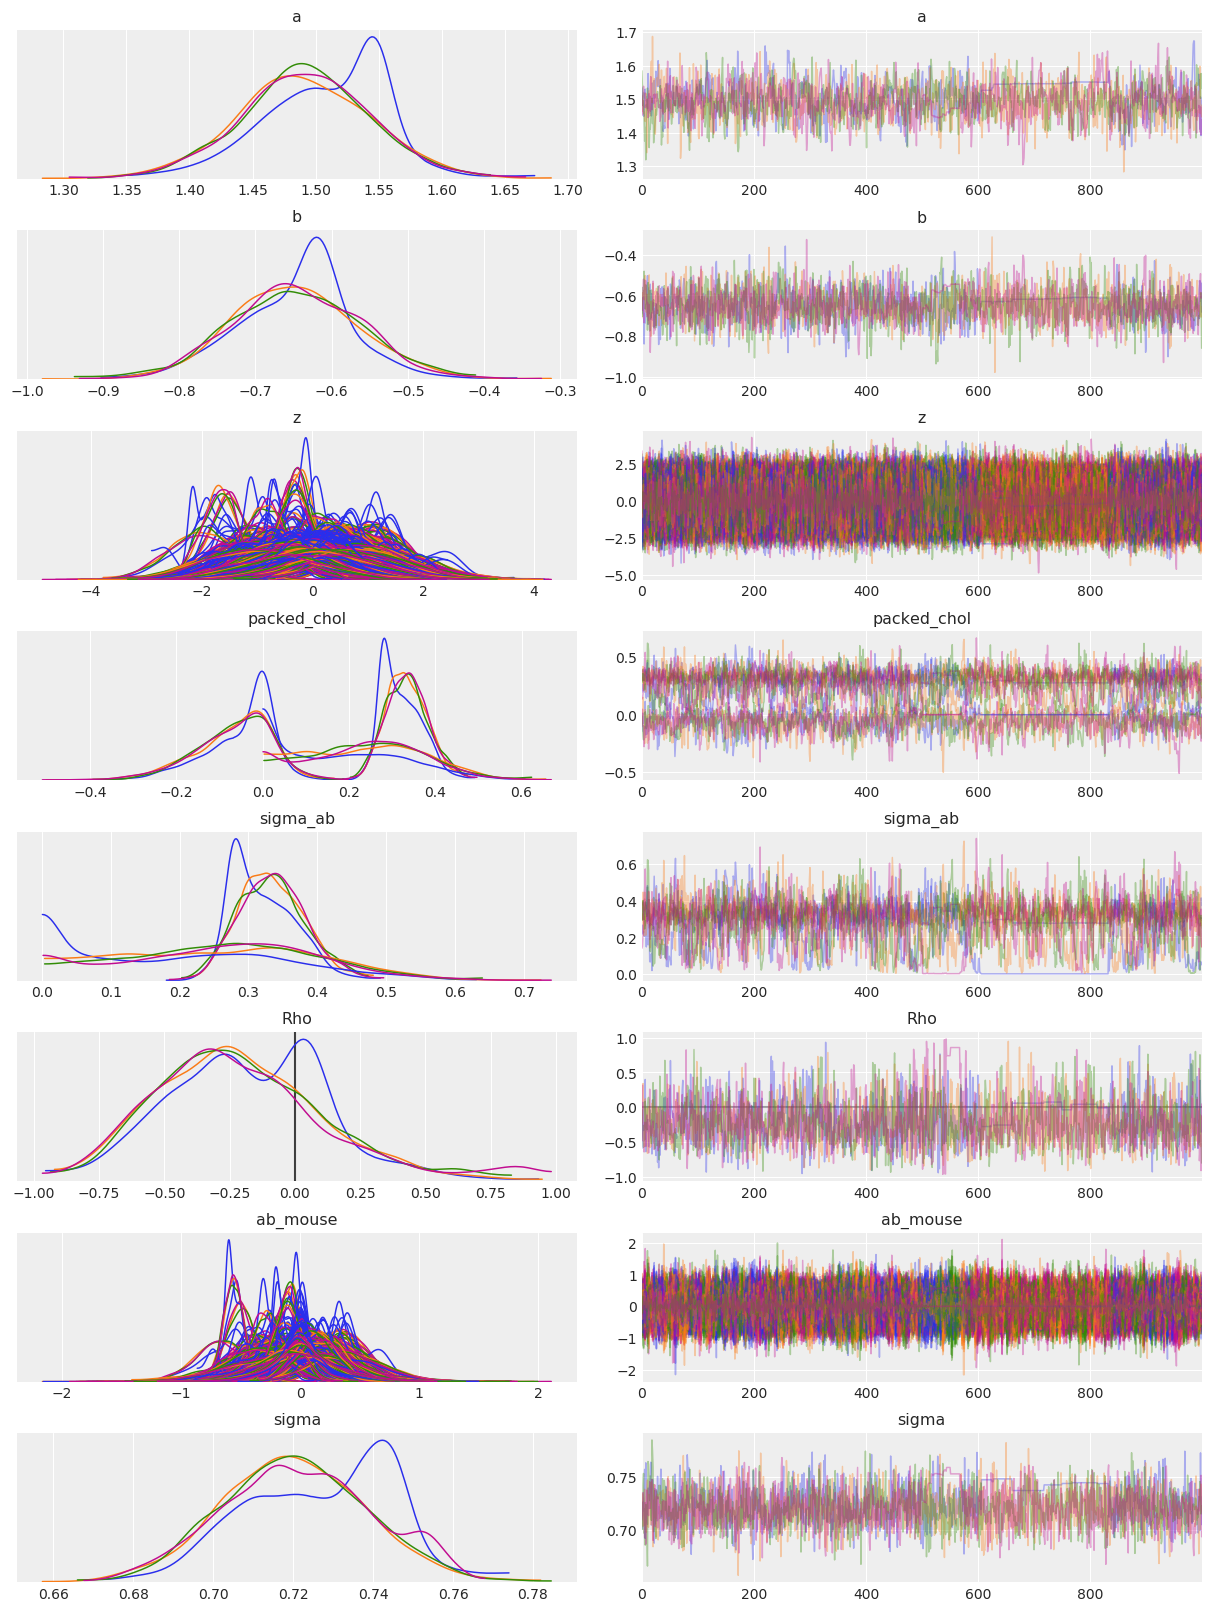

In [102]:
with pm.Model() as covariation_intercept_slope:
    # prior stddev in intercepts & slopes (variation across mice):
    sd_dist = pm.Exponential.dist(0.5)
    packed_chol = pm.LKJCholeskyCov('packed_chol', eta=2, n=2, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    
    # extract standard deviations and rho:
    cov = pm.math.dot(chol, chol.T)
    sigma_ab = pm.Deterministic('sigma_ab', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    # prior for average intercept:
    a = pm.Normal('a', mu=0., sigma=5.)
    # prior for average slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    # population of varying effects:
    z = pm.Normal('z', 0., 1., shape=(2, n_mice))
    ab_mouse = pm.Deterministic('ab_mouse', tt.dot(chol, z).T)
    
    # Expected value per mouse:
    theta = a + ab_mouse[mouse, 0] + (b + ab_mouse[mouse, 1]) * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    covariation_intercept_slope_trace = pm.sample(1000, tune=6000, target_accept=0.99, random_seed=RANDOM_SEED)
    
az.plot_trace(covariation_intercept_slope_trace, lines=[("Rho", {}, 0.)], compact=True);

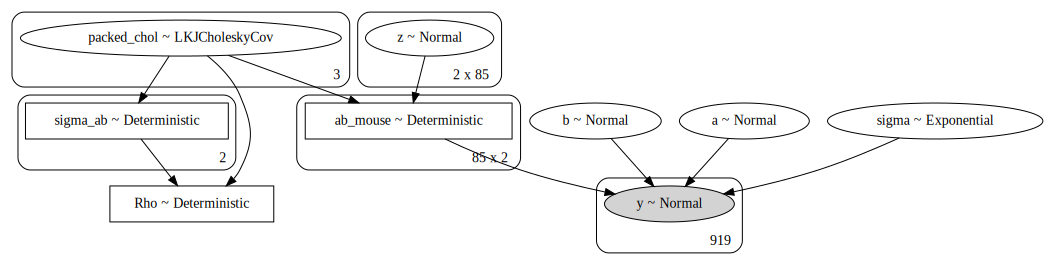

In [103]:
pm.model_to_graphviz(covariation_intercept_slope)

So the correlation between slopes and intercepts seems to be negative: when `a_mouse` increases, `b_mouse` tends to decrease. In other words, when stim firingrate in a mouse gets bigger, the difference with no_stim firingrate tends to get bigger too (because no_stim readings get smaller while stim readings get bigger). But again, the uncertainty is wide on `Rho` so it's possible the correlation goes the other way around or is simply close to zero. 

And how much variation is there across mice? It's not easy to read `sigma_ab` above, so let's do a forest plot and compare the estimates with the model that doesn't include the covariation between slopes and intercepts:

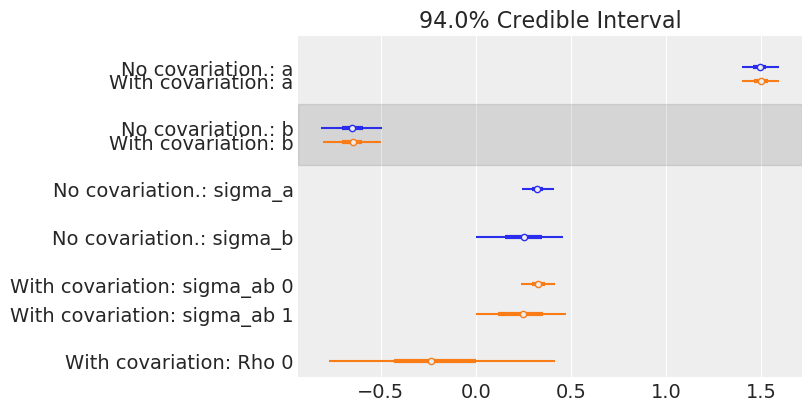

In [104]:
az.plot_forest(
    [varying_intercept_slope_trace, covariation_intercept_slope_trace], 
    model_names=["No covariation.", "With covariation"], 
    var_names=["a", "b", "sigma_a", "sigma_b", "sigma_ab", "Rho"], 
    combined=True,
    figsize=(8, 4)
);

The estimates are very close to each other, both for the means and the standard deviations. But remember, the information given by `Rho` is only seen at the mouse level: in theory it uses even more information from the data to get an even more informed pooling of information for all mouse parameters. So let's visually compare estimates of both models at the mouse level:

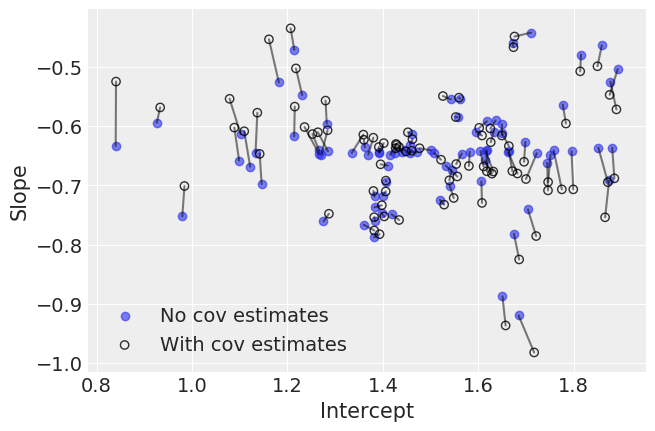

In [105]:
# posterior means of covariation model:
a_mouse_cov = (
    covariation_intercept_slope_trace['a'].mean()
    + covariation_intercept_slope_trace['ab_mouse'].mean(axis=0)[:, 0]
)
b_mouse_cov = (
    covariation_intercept_slope_trace['b'].mean()
    + covariation_intercept_slope_trace['ab_mouse'].mean(axis=0)[:, 1]
)

# plot both and connect with lines
plt.scatter(avg_a_mouse, avg_b_mouse, label="No cov estimates", alpha=0.6)
plt.scatter(a_mouse_cov, b_mouse_cov, facecolors='none', edgecolors='k', lw=1, label="With cov estimates", alpha=0.8)
plt.plot([avg_a_mouse, a_mouse_cov], [avg_b_mouse, b_mouse_cov], 'k-', alpha=.5)
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.legend();

The negative correlation is somewhat clear here: when the intercept increases, the slope decreases. So we understand why the model put most of the posterior weight into negative territory for `Rho`. Nevertheless, the negativity isn't *that* obvious, which is why the model gives a non-trivial posterior probability to the possibility that `Rho` could in fact be zero or positive.

Interestingly, the differences between both models occur at extreme slope and intercept values. This is because the second model used the slightly negative correlation between intercepts and slopes to adjust their estimates: when intercepts are *larger* (smaller) than average, the model pushes *down* (up) the associated slopes.

Globally, there is a lot of agreement here: modeling the correlation didn’t change inference that much. We already saw that firingrate levels tended to be lower in no_stims than stims, and when we checked the posterior distributions of the average effects (`a` and `b`) and standard deviations, we noticed that they were almost identical. But on average the model with covariation will be more accurate -- because it squeezes additional information from the data, to shrink estimates in both dimensions.

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected firingrate value, specify another regression model with a mouse-level covariate. Here, we use the mouse velocity reading $u_j$ (originally uranium level per county), which is thought to be related to firingrate levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a neuron-level predictor (no_stim or stim) as well as a mouse-level predictor (velocity).

Note that the model has both indicator variables for each mouse, plus a mouse-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation, $\sigma_{\alpha}$ (here it would be the variation across mice, `sigma_a`). An important implication of this is that the group-level estimate induces stronger pooling -- by definition, a smaller $\sigma_{\alpha}$ means a stronger shrinkage of mice parameters towards the overall state mean. 

This is fairly straightforward to implement in PyMC3 -- we just add another level:

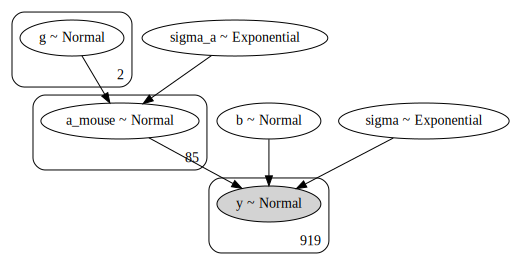

In [45]:
with pm.Model() as hierarchical_intercept:
    # Hyperpriors:
    g = pm.Normal('g_neuron', mu=0., sigma=10., shape=2)
    sigma_a = pm.Exponential('sigma_a', 1.)

    # Varying intercepts velocity model:
    a = g[0] + g[1] * u
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.)

    # Expected value per mouse:
    theta = a_mouse[mouse] + b * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)

    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(hierarchical_intercept)

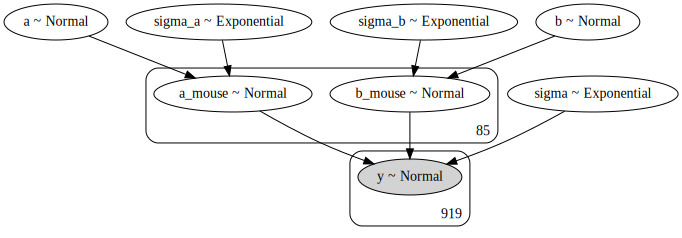

In [50]:
# compare to no velocity:
with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=5.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.)
    sigma_b = pm.Exponential('sigma_b', 0.5)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Varying slopes:
    b_mouse = pm.Normal('b_mouse', mu=b, sigma=sigma_b, shape=n_mice)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b_mouse[mouse] * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
pm.model_to_graphviz(varying_intercept_slope)

Do you see the new level, with `sigma_a` and `g`, which is two-dimensional because it contains the linear model for `a_mouse`? Now, if we run this model we're gonna get... divergences, you guessed it! So we're gonna switch to the non-centered form again:

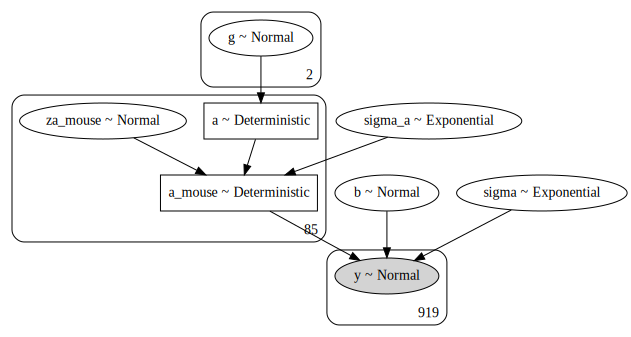

In [46]:
with pm.Model() as hierarchical_intercept:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=2)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts velocity model:
    a = pm.Deterministic('a', g[0] + g[1] * u)
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    a_mouse = pm.Deterministic('a_mouse', a + za_mouse * sigma_a)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    
pm.model_to_graphviz(hierarchical_intercept)

In [120]:
with hierarchical_intercept:    
    hierarchical_intercept_trace = pm.sample(1000, tune=6000, target_accept=0.99, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, za_mouse, sigma_a, g]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:51<00:00, 540.04draws/s]
The number of effective samples is smaller than 25% for some parameters.


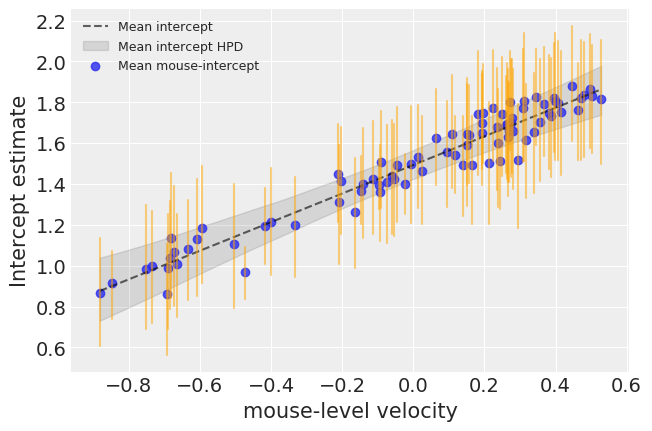

In [121]:
samples = hierarchical_intercept_trace
avg_a = samples['a'].mean(0)
avg_a_mouse = samples['a_mouse'].mean(0)

plt.plot(
    u[np.argsort(u)], 
    avg_a[np.argsort(u)], 
    "k--", 
    alpha=0.6,
    label="Mean intercept"
)
az.plot_hpd(
    u, 
    samples['a'],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"}
)

plt.scatter(u, avg_a_mouse, alpha=0.8, label="Mean mouse-intercept")
for ui, l, h in zip(
    u, 
    az.hpd(samples["a_mouse"])[:, 0], 
    az.hpd(samples["a_mouse"])[:, 1]
):
    plt.plot([ui, ui], [l, h], alpha=0.5, c="orange")

plt.xlabel("mouse-level velocity"); plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

Velocity is indeed much associated with baseline firingrate levels in each mouse. The graph above shows the average relationship and its uncertainty: the baseline firingrate level in an average mouse as a function of velocity, as well as the 94% HPD of this firingrate level (grey line and envelope). The blue points and orange bars represent the relationship between baseline firingrate and velocity, but now for each mouse. As you see, the uncertainty is bigger now, because it adds on top of the average uncertainty -- each mouse has its idyosyncracies after all.

If we compare the mouse-intercepts for this model with those of the partial-pooling model without a mouse-level covariate:

In [26]:
az.plot_forest(
    [varying_intercept_trace, hierarchical_intercept_trace], 
    model_names=["W/t. mouse pred.", "With mouse pred."], 
    var_names=["a_mouse"], 
    combined=True,
    figsize=(6, 40)
);

NameError: name 'varying_intercept_trace' is not defined

We see that the compatibility intervals are narrower for the model including the mouse-level covariate. This is expected, as the effect of a covariate is to reduce the variation in the outcome variable -- provided the covariate is of predictive value. More importantly, with this model we were able to squeeze even more information out of the data.

## Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

To add these effects to our model, let's create a new variable containing the mean of `no_stim` in each mouse and add that to our previous model:

In [ ]:
avg_no_stim = srrs_mn.groupby('mouse')['no_stim'].mean().rename(mouse_lookup).values

with pm.Model() as contextual_effect:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=3)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts velocity model:
    a = pm.Deterministic('a', g[0] + g[1] * u + g[2] * avg_no_stim)
    za_mouse = pm.Normal('za_mouse', mu=0., sigma=1., shape=n_mice)
    a_mouse = pm.Deterministic('a_mouse', a + za_mouse * sigma_a)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.)
    
    mouse_idx = pm.intX(pm.Data('mouse_idx', mouse))
    no_stim_vals = pm.Data('no_stim_vals', no_stim)
    # Expected value per mouse:
    theta = a_mouse[mouse_idx] + b * no_stim_vals
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_firingrate)
    pm.model_to_graphviz(contextual_effect)    
    
    contextual_effect_trace = pm.sample(1000, tune=8000, target_accept=0.99, random_seed=RANDOM_SEED)
az.summary(contextual_effect_trace, var_names=["g"], round_to=2)

In [ ]:
pm.model_to_graphviz(contextual_effect)

So we might infer from this that mice with higher proportions of neurons without stims tend to have higher baseline levels of firingrate. This seems to be new, as up to this point we saw that `no_stim` was *negatively* associated with firingrate levels. But remember this was at the neuron-level: firingrate tends to be higher in neurons with stims. But at the mouse-level it seems that the less stims on average in the mouse, the more firingrate. So it's not that contradictory. What's more, the estimate for $\gamma_2$ is quite uncertain and overlaps with zero, so it's possible that the relationship is not that strong. And finally, let's note that $\gamma_2$ estimates something else than velocity's effect, as this is already taken into account by $\gamma_1$ -- it answers the question "once we know velocity level in the mouse, is there any value in learning about the proportion of neurons without stims?".

All of this is to say that we shouldn't interpret this causally: there is no credible mecanism by which a stim (or absence thereof) *causes* firingrate emissions. More probably, our causal graph is missing something: a confounding variable, one that influences both stim construction and firingrate levels, is lurking somewhere in the dark... Perhaps is it the type of soil, which might influence what type of structures are built *and* the level of firingrate? Maybe adding this to our model would help with causal inference.

## Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an *existing* group
2. a new individual within a *new* group

The first type is the easiest one, as we've generally already sampled from the existing group. For this model, the first type of posterior prediction is the only one making sense, as mice are not added or deleted every day. So, if we wanted to make a prediction for, say, a new neuron with no stim in St. Louis mouse, we just need to sample from the firingrate model with the appropriate intercept:

In [ ]:
mouse_lookup["ST LOUIS"]

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

Because we judiciously set the mouse index and no_stim values as shared variables earlier, we can modify them directly to the desired values (69 and 1 respectively) and sample corresponding posterior predictions, without having to redefine and recompile our model. Using the model just above:

In [ ]:
with contextual_effect:
    pm.set_data({
        "mouse_idx": np.array([69]),
        "no_stim_vals": np.array([1])
    })
    stl_pred = pm.sample_posterior_predictive(contextual_effect_trace, random_seed=RANDOM_SEED)
az.plot_posterior(stl_pred);

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data.

- Estimation of coefficients for (under-represented) groups.

- Incorporating individual- and group-level information when estimating group-level coefficients.

- Allowing for variation among individual-level coefficients across groups.

## References

- Gelman, A., & Hill, J. (2006), *Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.)*, Cambridge University Press.

- Gelman, A. (2006), *Multilevel (Hierarchical) modeling: what it can and cannot do*, Technometrics, 48(3), 432–435.

- McElreath, R. (2020), *Statistical Rethinking - A Bayesian Course with Examples in R and Stan (2nd ed.)*, CRC Press. 